# Core import for prompt maker

> Best practice to use the prompt

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

# Basic Imports  

In [ ]:
#| export
from fasthtml.common import *
from monsterui.all import *
from lisette import *
import json, uuid

In [ ]:
from fastcore.all import L

In [ ]:
show_doc(L)

---

[source](https://github.com/AnswerDotAI/fastcore/blob/main/fastcore/foundation.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### L

>      L (items=None, *rest, use_list=False, match=None)

*Behaves like a list of `items` but can also index with list of indices or masks*

In [ ]:
show_doc(H1)

---

[source](https://github.com/AnswerDotAI/MonsterUI/blob/main/monsterui/franken.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### H1

>      H1 (*c:fastcore.xml.FT|str, cls:enum.Enum|str|tuple=(), **kwargs)

*H1 with styling and appropriate size*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| c | fastcore.xml.FT \| str |  | Contents of H1 tag (often text) |
| cls | enum.Enum \| str \| tuple | () | Classes in addition to H1 styling |
| kwargs | VAR_KEYWORD |  |  |
| **Returns** | **FT** |  | **H1(..., cls='uk-h1')** |

# Initializing app with live debug mode. 

In [ ]:
#| export
app,rt = fast_app(
    hdrs=Theme.blue.headers(),
    live=True,   # Enable live reload
    debug=True   # Enable debug mode for better error messages
)


# Basic components and temp for import

In [ ]:
#| export
components = [("role", "Role & Persona"), ("task", "Task Definition"), ("format", "Output Format"), ("examples", "Examples")]
models = [("gpt-4", "GPT-4"), ("gpt-3.5-turbo", "GPT-3.5"), ("claude-3", "Claude 3")]
presets = [("", "Select a preset..."), ("content", "Content Creator"), ("tutor", "Educational Tutor"), ("analyst", "Business Analyst"), ("coder", "Code Assistant")]
progress_state = {}

def apply_preset(preset_type):
    if preset_type == "content": return dict(components=["role", "task", "format"], role_text="You are a skilled content creator", criteria="Create engaging content")
    if preset_type == "tutor": return dict(components=["role", "examples", "format"], role_text="You are an expert educator", criteria="Explain concepts clearly")
    if preset_type == "analyst": return dict(components=["role", "task", "format"], role_text="You are a business analyst", criteria="Analyze business scenarios")
    if preset_type == "coder": return dict(components=["role", "task", "examples"], role_text="You are an expert programmer", criteria="Help with coding tasks")
    return {}

# code 

In [ ]:
#| export
def generate_prompt_content(criteria, components, model='openai/gpt-4o'):
    comp_list = ", ".join([c for c in components])
    system_msg = "You are an expert at crafting effective LLM prompts. Generate specific, detailed content for each requested component."
    user_msg = f"""Given this user request: "{criteria}"

Generate content for these components: {comp_list}

Return a JSON object with keys matching the component names. For each component provide specific, actionable text (not generic placeholders).

Available components:
- role: Define the AI's expertise and persona
- task: Specific instructions for what to do
- format: How to structure the output
- examples: Concrete examples demonstrating the desired output

Return ONLY valid JSON, no other text."""
    chat = Chat(model, sp=system_msg)
    response = chat(user_msg)
    return response.choices[0].message.content
    

In [ ]:
#| export
def parse_llm_response(content):
    if content.startswith('```json'): content = content[7:]
    if content.startswith('```'): content = content[3:]
    if content.endswith('```'): content = content[:-3]
    return json.loads(content.strip())
    

index page

In [ ]:
#| export
@rt('/')
def get(preset: str = ""):
    data = apply_preset(preset) if preset else {}
    components_checked = data.get("components", [])
    return Form(
        Grid(
            Card(H3("Select & Customize Components"), *[Div(LabelCheckboxX(comp[1], name="components", value=comp[0], checked=comp[0] in components_checked, cls='mb-2'), TextArea(data.get(f"{comp[0]}_text", ""), placeholder=f"Enter your {comp[1].lower()}...", name=f"{comp[0]}_text", rows=2, cls='w-full mt-1 mb-3')) for comp in components]),
            Card(H3("Configuration"), Div(Select(*[Option(p[1], value=p[0], selected=p[0]==preset) for p in presets], name="preset", id="preset-select", cls='w-full mb-2'), Button("Apply Preset", onclick="window.location.href='/?preset='+document.querySelector('select[name=preset]').value", cls=ButtonT.secondary + ' mb-4')), Select(*[Option(m[1], value=m[0]) for m in models], name="model", cls='w-full mb-4'), H4("Main Criteria"), TextArea(data.get("criteria", ""), placeholder="Describe what you want your prompt to do...", name="criteria", rows=6, cls='w-full mb-4'), Button("Generate Prompt", cls=ButtonT.primary, hx_post="/generate", hx_include="form", hx_target="#output")),
            cols=2, gap=4
        ),
        Card(H3("Generated Prompt"), Div("Your prompt will appear here...", id="output", cls='border p-4 min-h-32'))
    )
    

In [ ]:
#| export
@rt("/progress/{session_id}")
def get_progress(session_id: str):
    status = progress_state.get(session_id, {"progress": 0, "done": False})
    if status["done"]: return Div()
    return Progress(value=status["progress"], hx_get=f"/progress/{session_id}", hx_trigger="every 500ms", hx_swap="outerHTML")

In [ ]:
#| export
@rt("/generate", methods=["POST"])
async def generate(request):
    form_data = await request.form()
    criteria,components,model = form_data.get("criteria", ""),form_data.getlist("components"),form_data.get("model", "gpt-3.5-turbo")
    role_text,task_text,format_text,examples_text = form_data.get("role_text", ""),form_data.get("task_text", ""),form_data.get("format_text", ""),form_data.get("examples_text", "")
    if not criteria.strip(): return Div("Please enter some criteria first!", cls='text-red-500')
    session_id = str(uuid.uuid4())
    progress_state[session_id] = {"progress": 10, "done": False}
    form_json = json.dumps({"criteria": criteria, "components": components, "model": model, "role_text": role_text, "task_text": task_text, "format_text": format_text, "examples_text": examples_text, "session_id": session_id})
    return Div(Progress(value=10, hx_get=f"/progress/{session_id}", hx_trigger="load, every 500ms", hx_swap="outerHTML"), Div(id="final-output", hx_post=f"/generate-result", hx_trigger="load delay:100ms", hx_vals=form_json))


In [ ]:
@rt("/generate", methods=["POST"])
async def generate(request):
    form_data = await request.form()
    criteria,components,model = form_data.get("criteria", ""),form_data.getlist("components"),form_data.get("model", "gpt-3.5-turbo")
    role_text,task_text,format_text,examples_text = form_data.get("role_text", ""),form_data.get("task_text", ""),form_data.get("format_text", ""),form_data.get("examples_text", "")
    if not criteria.strip(): return Div("Please enter some criteria first!", cls='text-red-500')
    session_id = str(uuid.uuid4())
    progress_state[session_id] = {"progress": 10, "done": False}
    form_json = json.dumps({"criteria": criteria, "components": components, "model": model, "role_text": role_text, "task_text": task_text, "format_text": format_text, "examples_text": examples_text, "session_id": session_id})
    return Div(Progress(value=10, hx_get=f"/progress/{session_id}", hx_trigger="load, every 500ms", hx_swap="outerHTML"), Div(id="final-output", hx_post=f"/generate-result", hx_trigger="load delay:100ms", hx_vals=form_json))


In [ ]:
#| export
@rt("/generate-result", methods=["POST"])
async def generate_result(request):
    data = await request.form()
    session_id,criteria,components,model = data.get("session_id"),data.get("criteria"),data.getlist("components"),data.get("model")
    role_text,task_text,format_text,examples_text = data.get("role_text"),data.get("task_text"),data.get("format_text"),data.get("examples_text")
    progress_state[session_id] = {"progress": 30, "done": False}
    llm_content = generate_prompt_content(criteria, components if components else ["role", "task", "format"])
    progress_state[session_id] = {"progress": 80, "done": False}
    parsed = parse_llm_response(llm_content)
    prompt_parts = []
    if "role" in components: prompt_parts.append(f"# Role & Persona\n{role_text if role_text.strip() else parsed.get('role', 'You are an expert assistant.')}")
    if "task" in components: prompt_parts.append(f"# Task\n{task_text if task_text.strip() else parsed.get('task', criteria)}")
    if "format" in components: prompt_parts.append(f"# Output Format\n{format_text if format_text.strip() else parsed.get('format', 'Provide a clear, well-structured response.')}")
    if "examples" in components: 
        ex = parsed.get('examples', 'Include relevant examples where appropriate.')
        ex = ex if isinstance(ex, str) else json.dumps(ex, indent=2)
        prompt_parts.append(f"# Examples\n{examples_text if examples_text.strip() else ex}")
    if not prompt_parts: prompt_parts.append(f"# Request\n{criteria}")
    final_prompt = "\n\n".join(prompt_parts)
    progress_state[session_id] = {"progress": 100, "done": True}
    return Div(DivFullySpaced(P(f"Model: {model}", cls='font-bold'), Button("Copy", onclick="navigator.clipboard.writeText(document.getElementById('prompt-text').textContent); alert('Copied!');", cls=ButtonT.ghost)), Pre(final_prompt, id="prompt-text", cls='border p-4 rounded bg-gray-50 text-sm whitespace-pre-wrap mt-2'))

In [ ]:
#| export
serve()

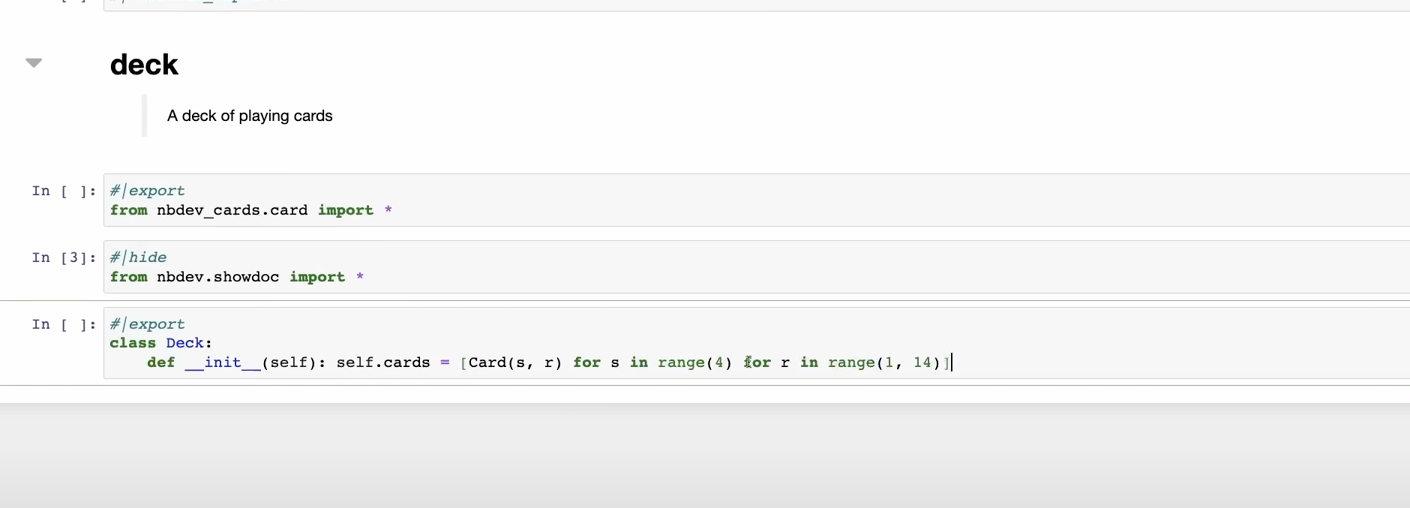